<a id="top"></a>
# NLP Hotel Review Classification
---
### *Notebook 3/3: Neural Network & Pretrained Model Building*
---

## Contents
---

**1.  [Data Reading & Preparation](#data_reading_prep)** <br>
**2.  [Neural Network Model 1 - Dense](#model_1)** <br>
**3.  [Neural Network Model 2 - Embedding](#model_2)** <br>
**4.  [Neural Network Model 3 - Convolutional](#model_3)** <br>
**5.  [Evaluate Best Neural Network Model](#best_nn_model)** <br>
**6.  [BERT Model](#bert_model)** <br>
**7.  [Model Summary](#model_summary)** <br>
**8.  [Model Deployment](#model_deployment)** <br>

---

<a id="data_reading_prep"></a>
## 1. Data Reading & Preparation

In [2]:
# Imports
from helper_functions import acc_loss_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, Embedding, Conv1D, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import ktrain
from ktrain import text

In [3]:
# Read in data
df = pd.read_csv('drive/MyDrive/data/df_final.csv')

In [4]:
# Check data
df

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice room not experience hotel monaco seattle ...,3
2,excellent staff housekeeping quality hotel cho...,4
3,poor value stayed monaco seattle july nice hot...,2
4,nice hotel not nice staff hotel lovely staff q...,3
...,...,...
18535,dirty hall dirty room nothing work tv didn wor...,1
18536,confortable room staff kind available polite g...,5
18537,stayed attending itb berlin heating system hot...,2
18538,hotel well located adenauerplatz ku damm reaso...,2


In [5]:
# Save all class names
class_names = np.sort(df['Rating'].unique()).tolist()

<a id="model_1"></a>
## 2. Neural Network Model 1 - Dense
---

For our first neural network model, let's try starting out with just a simple dense architecture. We will need to vectorize our reviews as before and also label encode our ratings. We will also need to one hot encode our labels for this type of model.

In [6]:
# Split data
X1 = df['Review']
y1 = df['Rating']

# 80% Train, 10% Validation, 10% Test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=.2, 
                                                    stratify=y1, random_state=42)

X1_val, X1_test, y1_val, y1_test = train_test_split(X1_test, y1_test, test_size=.5, 
                                                stratify=y1_test, random_state=42)

In [7]:
# Vectorize data
tfidf = TfidfVectorizer()
X1_train = tfidf.fit_transform(X1_train).toarray()
X1_val = tfidf.transform(X1_val).toarray()
X1_test = tfidf.transform(X1_test).toarray()

In [8]:
# Encode labels (shifts labels from 1-5 to 0-4)
le = LabelEncoder()
y1_train = le.fit_transform(y1_train)
y1_val = le.transform(y1_val)
y1_test = le.transform(y1_test)

In [9]:
# One hot encode labels ready for model
y1_train  = np_utils.to_categorical(y1_train)
y1_val = np_utils.to_categorical(y1_val)
y1_test = np_utils.to_categorical(y1_test)

In [10]:
# Show labels for training data
y1_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

Here we can see the labels in their one hot encoded form.

For the first neural network model, we will use the following architecture.

In [11]:
# Build model architecture
model_1 = Sequential()
model_1.add(Dense(32, input_dim=X1_train.shape[1], activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(BatchNormalization())
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(5, activation='sigmoid'))

In [12]:
# Compile model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# Fit data
epochs = 10
history_1 = model_1.fit(
    X1_train, y1_train, batch_size=128, epochs=epochs, 
    verbose=0, validation_data=(X1_val, y1_val)
)

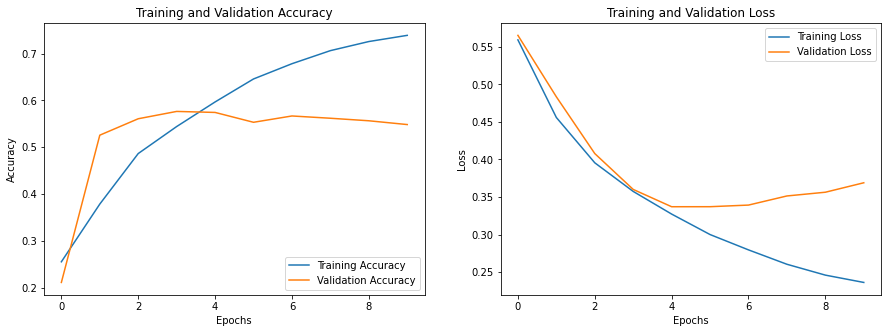

In [14]:
# Plot accuracy and loss
acc_loss_plot(history_1, epochs)

We can see that after around 4 epochs, the validation loss starts increasing. Accuracy also plateaus pretty quickly.

In [15]:
# Evaluate model on validation set
model_1.evaluate(X1_val, y1_val)[1]

58/58 [==============================] - 0s 4ms/step - loss: 0.3689 - accuracy: 0.5485


0.5485436916351318

In [16]:
# Evaluate model on test set
model_1_accuracy = model_1.evaluate(X1_test, y1_test)[1]
model_1_accuracy

58/58 [==============================] - 0s 4ms/step - loss: 0.3580 - accuracy: 0.5874


0.5873786211013794

The accuracy of the model is around the same as what we were seeing with some of our earlier classification models.

In [17]:
# Save model 1
model_1.save('drive/MyDrive/models/nn_model_1.h5')

<a id="model_2"></a>
## 3. Neural Network Model 2 - Embedding
---

Let's try using a model with an embedding layer. For this model, we will vectorize the reviews by assigning each unique word a number. We will also set a maximum length for the review and pad any reviews which are shorter than the maximum length.

In [18]:
# One hot encode labels
df_ohe = pd.get_dummies(df, columns=['Rating'])
df_ohe

,Review,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5
0,ok nothing special charge diamond member hilto...,0,1,0,0,0
1,nice room not experience hotel monaco seattle ...,0,0,1,0,0
2,excellent staff housekeeping quality hotel cho...,0,0,0,1,0
3,poor value stayed monaco seattle july nice hot...,0,1,0,0,0
4,nice hotel not nice staff hotel lovely staff q...,0,0,1,0,0
...,...,...,...,...,...,...
18535,dirty hall dirty room nothing work tv didn wor...,1,0,0,0,0
18536,confortable room staff kind available polite g...,0,0,0,0,1
18537,stayed attending itb berlin heating system hot...,0,1,0,0,0
18538,hotel well located adenauerplatz ku damm reaso...,0,1,0,0,0


In [19]:
# Split data into training, validation and test
X2 = df_ohe.loc[:,['Review']]
y2 = np.array(df_ohe.drop('Review', axis=1))

# 80% Train, 10% Validation, 10% Test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=.2, 
                                                    stratify=y2, random_state=42)

X2_val, X2_test, y2_val, y2_test = train_test_split(X2_test, y2_test, test_size=.5, 
                                                stratify=y2_test, random_state=42)

In [20]:
# Join all reviews in training set and split
train_words = " ".join(X2_train['Review'].values).split()

In [21]:
# All words
len(train_words)

1122445

We can see that we have a total of 1,122,445 words in our reviews. To extract just the unique words, we can convert the list to a set.

In [22]:
# Get all unique words only
train_unique = set(train_words)

In [23]:
# Number of unique words
len(train_unique)

30191

After extracting just the unique words, we are left with 30,191 words. Now we can assign each unique word a number based on its index within the set.

In [24]:
# Factorize all unique words (assign each word a unique number)
unique_idx = pd.factorize(list(train_unique))[0]

In [25]:
# Check data
list(zip(train_unique, unique_idx))[:10]

[('stazione', 0),
 ('insider', 1),
 ('instance', 2),
 ('minutues', 3),
 ('reccomendation', 4),
 ('ml', 5),
 ('golf', 6),
 ('beter', 7),
 ('doubltree', 8),
 ('dubious', 9)]

Let's put each word and its index into a dictionary to make it easier to access.

In [26]:
# Create dictionary for word and unique number
word_idx_zip = zip(train_unique, unique_idx)
word_idx = dict((x, y) for x, y in list(word_idx_zip))

We will also have to add numbers to our word index to represent empty space and unknown words. In this case, we will shift all dictionary entries by 2 so that we can assign padding an index of 0 and unknown words an index of 1.

In [27]:
# Adding padding and unknown for empty space and unknown words
word_idx = {k:(v+2) for k,v in word_idx.items()}
word_idx['<PAD>'] = 0
word_idx['<UNK>'] = 1

In [28]:
# Check size of dict
len(word_idx)

30193

With indices for padding and unknown words added, we now have a total of 30,193 unique word representations.

In [29]:
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

We can now apply our word representations to our data.

In [30]:
# Vectorize reviews in training set
X2_train['vect_review'] = X2_train['Review'].str.split().map(
    lambda x: [word_idx.get(word, word_idx['<UNK>']) for word in x]
)

In [31]:
# Check data
X2_train

,Review,vect_review
11117,stayed night last minute stop parking limited ...,"[16880, 12633, 28781, 1379, 29844, 15201, 1693..."
17749,hostel not used longer stay maybe young people...,"[25530, 13678, 27328, 10648, 19635, 21370, 442..."
9253,stayed night moment went room perfect clean mo...,"[16880, 12633, 21939, 21267, 22483, 13670, 415..."
9986,nice hotel nice architecture right river thame...,"[19409, 20273, 19409, 6713, 15751, 340, 28450,..."
17853,first arrive check time room isn ready hour la...,"[8222, 18185, 22537, 13000, 22483, 7640, 12528..."
...,...,...
95,great location reservation mixup great hotel s...,"[16158, 25801, 4439, 10610, 16158, 20273, 3177..."
15433,location really great near metro station marke...,"[25801, 23252, 16158, 16193, 25371, 21910, 263..."
7513,very basic small single bed called double no s...,"[11735, 15424, 28368, 1737, 28028, 10071, 2469..."
12423,needed hotel stay only london day recommended ...,"[10771, 20273, 19635, 23365, 16355, 3777, 2536..."


In [32]:
# Vectorize reviews in validation set
X2_val['vect_review'] = X2_val['Review'].str.split().map(
    lambda x: [word_idx.get(word, word_idx['<UNK>']) for word in x]
)

In [33]:
# Check data
X2_val

,Review,vect_review
15471,friend stayed three night called hotel simply ...,"[24036, 16880, 25727, 12633, 10071, 20273, 160..."
12316,experience good room rather small basically no...,"[13783, 19918, 22483, 13539, 28368, 18525, 112..."
10604,got very worst hotel ever stayed value disgrac...,"[11688, 11735, 24946, 20273, 12930, 16880, 126..."
15457,one major negative aspect hotel wifi not free ...,"[18567, 24654, 24113, 28173, 20273, 7625, 1367..."
10227,hotel fraud booked room holiday one day move r...,"[20273, 26494, 1768, 22483, 16302, 18567, 3777..."
...,...,...
2713,not recommended stayed labor day weekend paid ...,"[13678, 25363, 16880, 2302, 3777, 7807, 1410, ..."
7572,room very small staff make not telling truth f...,"[22483, 11735, 28368, 13209, 15297, 13678, 656..."
5899,good location stayed night ginza tsukiji fish ...,"[19918, 25801, 16880, 12633, 28981, 4612, 2966..."
8969,want bed night premier always reliable first t...,"[15316, 28028, 12633, 13914, 717, 22407, 8222,..."


In [34]:
# Vectorize reviews in test set
X2_test['vect_review'] = X2_test['Review'].str.split().map(
    lambda x: [word_idx.get(word, word_idx['<UNK>']) for word in x]
)

Next, we will set our max length to be 200 and add padding.

In [35]:
# Add padding to reviews and cap length
X2_train = sequence.pad_sequences(
    X2_train['vect_review'], value=word_idx['<PAD>'], padding='post', maxlen=200
)

X2_val = sequence.pad_sequences(
    X2_val['vect_review'], value=word_idx['<PAD>'], padding='post', maxlen=200
)

X2_test = sequence.pad_sequences(
    X2_test['vect_review'], value=word_idx['<PAD>'], padding='post', maxlen=200
)

In [36]:
# Example
X2_train[9]

array([ 6133, 20270,  1054, 12633,  4798, 20273, 19448, 23502, 13482,
        7517,  1054, 12633,  2011, 28384, 25279, 16962,  2459, 28544,
       19131, 12351, 21910, 17247, 13823, 10690, 22483, 21242,   346,
       17084, 21276, 12633, 13357, 24695, 28028,  1737, 28028, 21709,
        8010, 23365,  1054, 24463,  7153,  5253,  3722, 22483, 13539,
        7615,  1768, 22483, 22483, 26266, 13678, 23365, 19118, 25399,
       22483, 15221, 28028,  4677, 22483,  5824,  6747,  2408,  8538,
        7527, 25399, 22483, 23365,  1054, 28028, 25019, 24715, 12659,
       24975,   981, 16163, 30108,  6747,  2408, 10205, 10686,  2393,
       16522, 20010,  6371, 15221, 28028, 23365, 18567,  3701, 21053,
       23511, 22483, 26357, 23293, 26766, 22483, 24695, 28028, 29750,
       20273,  6126, 17959,  3239, 22483, 19847,  8966, 22483,  2332,
       27004,  2578, 25367, 22177, 17245, 14485, 26761, 21223, 21820,
        2543, 24129,  5913,  7841, 25367, 23365,  1737,  7885, 24770,
        4011, 28522,

Above is an example of what one of our reviews now looks like. Each number above 1 represents a word. A value of 0 represents empty space and a value of 1 represents an unknown word i.e. a word that has not been seen in the training data. As this review is from the training data, it will not contain the number 1.

In this model architecture, we will use an embedding input layer. We will then pool the features using a global average pooling layer before feeding them into a fully connected layer.

In [37]:
# Build model architecture
model_2 = Sequential()
model_2.add(Embedding(len(word_idx), 32))
model_2.add(GlobalAveragePooling1D())
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(5, activation='sigmoid'))

In [38]:
# View model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          966176    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 967,397
Trainable params: 967,397
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Compile model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Fit model
epochs = 50
history_2 = model_2.fit(
    X2_train, y2_train, batch_size=250, epochs=epochs, validation_data=(X2_val, y2_val), 
    callbacks=[early_stopping], verbose=0
)

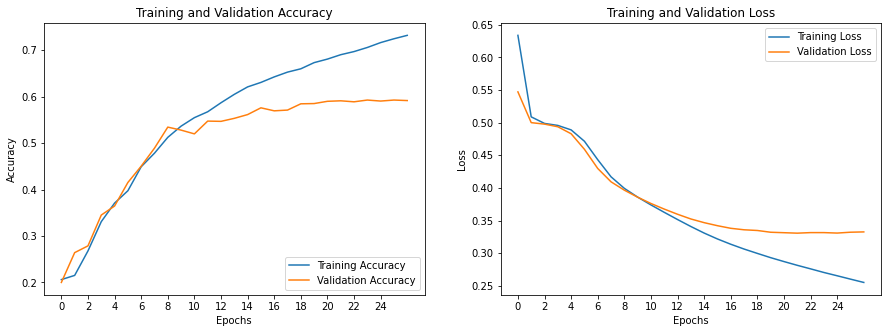

In [41]:
# Plot accuracy and loss
last_epoch = early_stopping.stopped_epoch
acc_loss_plot(history_2, last_epoch)

We can see that this model performed slighlty better than our initial neural network. The training and validation loss stays together for longer before it starts to diverge at around epoch 12. Accuracy also starts to plateau again around 0.6.

In [42]:
# Evaluate model on validation set
model_2.evaluate(X2_val, y2_val)[1]

58/58 [==============================] - 0s 3ms/step - loss: 0.3326 - accuracy: 0.5917


0.591693639755249

In [43]:
# Evaluate model on test set
model_2_accuracy = model_2.evaluate(X2_test, y2_test)[1]
model_2_accuracy

58/58 [==============================] - 0s 3ms/step - loss: 0.3423 - accuracy: 0.5895


0.5895361304283142

Test accuracy for this model is marginally better than our first neural network model.

In [44]:
# Save model 2
model_2.save('drive/MyDrive/models/nn_model_2.h5')

<a id="model_3"></a>
## 4. Neural Network Model 3 - Convolutional
---

For our final neural network model, we will use an architecture that uses a convolutional layer to extract features. For this model, we can use the same training, validation and test data that we used for the previous model.

In [45]:
# Build convolutional model architecture
model_3 = Sequential()
model_3.add(Embedding(len(word_idx), 32))
model_3.add(Conv1D(128, 5, activation='relu'))
model_3.add(GlobalAveragePooling1D())
model_3.add(Dense(10, activation='relu'))
model_3.add(Dense(5, activation='sigmoid'))

In [46]:
# Compile model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
# Model summary
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          966176    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         20608     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
Total params: 988,129
Trainable params: 988,129
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Fit model
epochs = 50
history_3 = model_3.fit(
    X2_train, y2_train, batch_size=250, epochs=epochs, validation_data=(X2_val, y2_val), 
    callbacks=[early_stopping], verbose=0
)

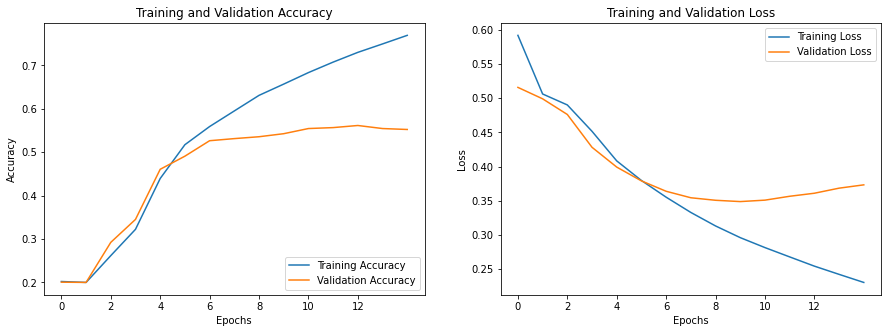

In [49]:
# Plot accuracy and loss
last_epoch = early_stopping.stopped_epoch
acc_loss_plot(history_3, last_epoch)

Again, we see very similar results with validation loss starting to increase around epoch 6 and validation accuracy plateauing between 0.5 and 0.6.

In [50]:
# Evaluate model on validation set
model_3.evaluate(X2_val, y2_val)[1]

58/58 [==============================] - 1s 7ms/step - loss: 0.3733 - accuracy: 0.5523


0.5523192882537842

In [51]:
# Evaluate model on test set
model_3_accuracy = model_3.evaluate(X2_test, y2_test)[1]
model_3_accuracy

58/58 [==============================] - 0s 3ms/step - loss: 0.3863 - accuracy: 0.5518


0.5517799258232117

As we can see, this model performed the worst out of all of our neural network models.

In [52]:
# Save model 3
model_3.save('drive/MyDrive/models/nn_model_3.h5')

<a id="best_nn_model"></a>
## 5. Evaluate Best Neural Network Model
---

Now let's take the model that performed the best and use it to predict our test set. This will help us to get a better idea of the model's actual performance if it were to be productionized. In this instance, the best model was model 2, the model with the embedding input layer.

In [53]:
# Select best model
best_model = model_2

Here, we will reverse one hot encode our test labels and add 1 so that they fall within the range of 1-5.

In [54]:
# Reverse one hot encode labels
y_test_rohe = np.argmax(y2_test, axis=1)+1 # For an array

We can also add 1 to our predictions to put them on the same scale (between 1 and 5).

In [55]:
# Make predictions with best neural network model
y_test_preds = np.argmax(best_model.predict(X2_test), axis=1)+1

In [56]:
# Get best model's final accuracy on test set
model_accuracy = accuracy_score(y_test_rohe, y_test_preds)

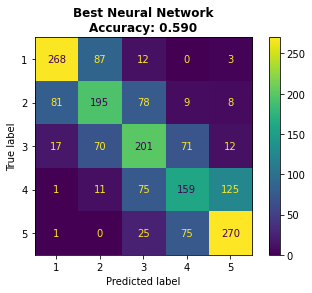

In [57]:
# Plot confusion matrix for best neural network model
cm = confusion_matrix(y_test_rohe, y_test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(values_format='d')
disp.ax_.set_title(f'Best Neural Network\nAccuracy: {model_accuracy:.3f}', fontweight='bold');

We can see that the model performs reasonably well but still does not beat the accuracy that we achieved with our Stacking Classifier. Let's see what accuracy we can achieve if we use a pretrained model.

<a id="bert_model"></a>
## 6. BERT Model
---

BERT, which stands for Bidirectional Encoder Representations from Transformers, is a language representation model  designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks. 

We can implement BERT using the ktrain library, a lightweight wrapper for the deep learning library TensorFlow Keras which helps to build, train, and deploy neural networks and other machine learning models.

In [58]:
# Check data
df

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice room not experience hotel monaco seattle ...,3
2,excellent staff housekeeping quality hotel cho...,4
3,poor value stayed monaco seattle july nice hot...,2
4,nice hotel not nice staff hotel lovely staff q...,3
...,...,...
18535,dirty hall dirty room nothing work tv didn wor...,1
18536,confortable room staff kind available polite g...,5
18537,stayed attending itb berlin heating system hot...,2
18538,hotel well located adenauerplatz ku damm reaso...,2


In [59]:
# Label encode targets
le = LabelEncoder()
df['Rating'] = le.fit_transform(df['Rating'])

As usual, let's split our data into training, validation and testing.

In [60]:
# Remove 10% of data for testing and 10% for validation
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)

In [61]:
# Get features and labels from test set
X_test = df_test['Review']
y_test = df_test['Rating']

In [62]:
# Split & preprocess training and validation data
(X_train, y_train), (X_val, y_val), preproc = text.texts_from_df(df_train, 'Review', 
                                                                 label_columns=['Rating'],
                                                                 val_df=df_val, 
                                                                 preprocess_mode='bert',
                                                                 random_state=42)

['Rating_0', 'Rating_1', 'Rating_2', 'Rating_3', 'Rating_4']
      Rating_0  Rating_1  Rating_2  Rating_3  Rating_4
1127       1.0       0.0       0.0       0.0       0.0
6725       0.0       0.0       0.0       1.0       0.0
4966       0.0       0.0       0.0       1.0       0.0
1799       1.0       0.0       0.0       0.0       0.0
4484       1.0       0.0       0.0       0.0       0.0
['Rating_0', 'Rating_1', 'Rating_2', 'Rating_3', 'Rating_4']
       Rating_0  Rating_1  Rating_2  Rating_3  Rating_4
11525       1.0       0.0       0.0       0.0       0.0
4024        0.0       0.0       0.0       0.0       1.0
16598       0.0       0.0       0.0       0.0       1.0
6987        0.0       0.0       0.0       0.0       1.0
13390       0.0       0.0       0.0       1.0       0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


To implement this model, I followed the documentation provided by ktrain at https://pypi.org/project/ktrain/

In [63]:
# Create model
bert_model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 400
done.


In [64]:
# Create learner
learner = ktrain.get_learner(model=bert_model, train_data=(X_train, y_train), val_data=(X_val, y_val),
                             batch_size=6)

In [65]:
# Fit data
history = learner.fit_onecycle(lr=2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
2472/2472 [==============================] - 3499s 1s/step - loss: 1.2958 - accuracy: 0.4217 - val_loss: 0.8427 - val_accuracy: 0.6257


We can see that this model achieves the best validation accuracy we have seen so far. Let's use this model to make a few predictions on some example data.

In [66]:
# Get predictor
predictor = ktrain.get_predictor(learner.model, preproc)

In [67]:
# Example prediction
example_data = [
        'The hotel was really bad I do not like it',
        'the room really sucked, I want my money back',
        'what a beautiful place'        
]

# Make predictions on example data
predictor.predict(example_data)

['Rating_0', 'Rating_0', 'Rating_4']

That looks about right. 'Rating_0' is equivalent to a rating of 1 in our original labels and 'Rating_4' is equivalent to a rating of 5. If we convert these labels back to our original labels, as shown below, we can see the actual ratings for these examples.

In [68]:
# Get original labels for predictions
label_dict = {
    'Rating_0': 1,
    'Rating_1': 2,
    'Rating_2': 3,
    'Rating_3': 4,
    'Rating_4': 5
}

[label_dict[k] for k in predictor.predict(example_data)]

[1, 1, 5]

In [69]:
# Evaluate model on validation set
learner.validate(val_data=(X_val, y_val), class_names=class_names)

              precision    recall  f1-score   support

           1       0.77      0.73      0.75       382
           2       0.54      0.61      0.57       365
           3       0.57      0.59      0.58       393
           4       0.50      0.49      0.49       330
           5       0.76      0.70      0.73       384

    accuracy                           0.63      1854
   macro avg       0.63      0.62      0.62      1854
weighted avg       0.63      0.63      0.63      1854



array([[278,  98,   6,   0,   0],
       [ 70, 221,  71,   3,   0],
       [ 11,  82, 232,  58,  10],
       [  1,   9,  85, 161,  74],
       [  1,   2,  14,  99, 268]])

Finally, we will use our model to predict our test set to ensure that our model will generalise well to new data.

In [70]:
# Get predictions using test set
test_preds = predictor.predict(X_test.to_list())

In [71]:
# Convert textual predictions and ground truth labels into arrays
y_preds_arr = np.array([int(x[-1]) for x in test_preds])
y_test_arr = np.array(y_test)

In [72]:
# Calculate BERT model test accuracy
bert_accuracy = accuracy_score(y_test_arr, y_preds_arr)

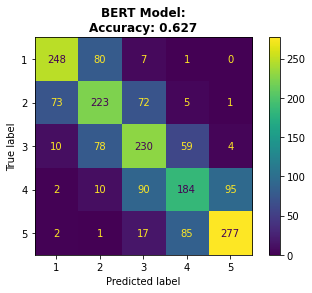

In [73]:
# Plot confusion matrix and accuracy for BERT model
cm = confusion_matrix(y_test_arr, y_preds_arr)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(values_format='d')
disp.ax_.set_title(f'BERT Model:\nAccuracy: {bert_accuracy:.3f}', fontweight='bold');

This is our most accurate model yet. However, like all of our other models, we can see that this model also confuses ratings which are close together. As mentioned before, this could reflect the subjective nature of how people leave and interpret reviews. For example, for one person, a rating of 4 might be considered really good but for others, anything lower than a 5 is unacceptable. Similarly, a rating of 3 for one person could just as easily be a 2 or 1 for somebody else.

In [84]:
# Save model and predictor
learner.save_model('drive/MyDrive/models/bert_model.h5')
predictor.save('drive/MyDrive/models/bert_model_predictor.h5')

<a id="model_summary"></a>
## 7. Model Summary

In [89]:
# Model summary
all_models_acc = [
    ('Neural Network Model 1', model_1_accuracy), 
    ('Neural Network Model 2', model_2_accuracy),
    ('Neural Network Model 3', model_3_accuracy),
    ('BERT Model', bert_accuracy)
]

all_models_df = pd.DataFrame(all_models_acc, columns=['model', 'accuracy']).set_index('model')
all_models_df.style.highlight_max(axis=0, color='#b3ff66').format("{:.3}")

,accuracy
model,
Neural Network Model 1,0.587
Neural Network Model 2,0.59
Neural Network Model 3,0.552
BERT Model,0.627


Here, we can see the accuracy of the models. Out of all of our models, including our initial classification models, the BERT model performs the best with an accuracy of 0.63.

<a id="model_deployment"></a>
## 8. Model Deployment
---

Although we have identified BERT as the best performing model, it is over 1GB in size. Our Stacking Classifier on the other hand performs almost as well and yet is only around 70MB. Therefore, we will use the Stacking Classifier model in our app as this should be easier to host and make inference faster. 

To create the app, we will use Streamlit, an open-source app framework for machine learning and data science projects. We will then deploy the app using Heroku.

**[Back to Top](#top)**